In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

In [2]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch import optim, cuda

from timeit import default_timer as timer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
img = "/content/drive/MyDrive/Dataset/HC18 (Medical Image)/training_set/000_HC_Annotation.png"
img1 = cv2.imread(img)
print(img1.shape)

(540, 800, 3)


In [5]:
rs = cv2.resize(img1, (256, 256))
print(rs.shape)

(256, 256, 3)


In [13]:
save_file_name = 'checkpoint.pt'
checkpoint = 'checkpoint.pth'
earlyStop=300
epochsNo=50

train_path='/content/drive/MyDrive/Dataset/HC18 (Medical Image)/training_set'
train_csv_path ='/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/training_set_pixel_size_and_HC.csv'
img_size = 256
cropped_img = 256
batch_size = 10

gpu = cuda.is_available()

In [7]:
df = pd.read_csv(os.path.join(train_csv_path))


df = df[['filename','pixel size(mm)','head circumference (mm)']].drop_duplicates()
df = df[['filename','pixel size(mm)','head circumference (mm)']].copy().rename(columns={'pixel size(mm)':'pixel_size','head circumference (mm)':'HC'})

# df['HC_pixels'] = df['HC'] / df['pixel_size']
# df['normalized_HC_pixels'] = df['HC_pixels'] / 1786.500242
df = df[df.filename.str.contains("_HC")]

train_df, test_val = train_test_split(df, test_size = 0.3,random_state = 2020)
valid_df, test_df = train_test_split(test_val, test_size = 0.5,random_state = 2020)

print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])
# train_df = train_df.groupby(['pixel_size', 'HC']).apply(lambda x: x.sample(4, replace = True)).reset_index(drop = True)
# print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])

df.describe()

train 564 validation 121 Test 121


,pixel_size,HC
count,806.000000,806.000000
mean,0.138848,173.971600
std,0.051949,64.761672
min,0.049415,44.300000
25%,0.108393,153.925000
50%,0.128191,174.225000
75%,0.157101,188.797500
max,0.393280,346.400000


In [8]:
train_df.to_csv("/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/train_file.csv", index=False, encoding='utf8')
valid_df.to_csv("/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/val_file.csv", index=False, encoding='utf8')
test_df.to_csv("/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/test_file.csv", index=False, encoding='utf8')

In [9]:
class HC_18(Dataset):
    def __init__(self, csv_path, train_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.train_path = train_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.train_path,self.df.iloc[idx, 0])
        image = Image.open(img_name)
        features = self.df.loc[idx,'HC']

        if self.transform:
            image = self.transform(image)
        return image , torch.tensor(features / 346.4)

In [14]:
#Image Transformation

image_transforms = {
    'train':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.RandomRotation(degrees=10),
            transforms.GaussianBlur(5),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

    'val':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.GaussianBlur(5),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

    'test':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.GaussianBlur(5),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

In [15]:
#Dataloader
train_filename='/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/train_file.csv'
val_filename='/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/val_file.csv'
test_filename='/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/test_file.csv'

data = {'train': HC_18(train_filename , train_path =  train_path ,transform = image_transforms['train']),
        'val': HC_18(val_filename , train_path =  train_path ,transform = image_transforms['val']),
        'test': HC_18(test_filename , train_path = train_path ,transform = image_transforms['test'])
       }
dataloaders ={
    'train': DataLoader(data['train'], batch_size=batch_size,shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size,shuffle=False),
    'test': DataLoader(data['test'], batch_size=len(test_df),shuffle=False)
}

In [12]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4

In [17]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7')

n_inputs = model._fc.in_features
model._fc = nn.Sequential(
    nn.Linear(n_inputs, 1 , bias = True)
)
if gpu:
    model = model.to('cuda')

Loaded pretrained weights for efficientnet-b7


In [18]:
#Training
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=1):
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []
    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch...\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        start = timer()

    # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            # Loss and backpropagation of gradients
            loss = criterion(output, target.float())
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Track training progress
            print( f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target.float())
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                history.append([train_loss, valid_loss])
                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \t\tValidation Loss: {valid_loss:.4f}')

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(f'\nEarly Stopping! Total epochs: {epoch+1}. Best epoch: {best_epoch+1} with loss: {valid_loss_min:.2f}')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch+1} with loss: {valid_loss_min:.2f}')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.')
    # Format history
    history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
    return model, history






In [19]:
# Optimizer
criterion=nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [20]:
#Training
model, history = train(model,criterion,optimizer,dataloaders['train'],dataloaders['val'],save_file_name=save_file_name,max_epochs_stop=earlyStop,n_epochs=epochsNo,print_every=1)
history.to_csv("/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/history.csv", index=False, encoding='utf8')

Starting Training from Scratch...



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch: 1 	Training Loss: 0.1205 		Validation Loss: 0.0982

Epoch: 2 	Training Loss: 0.0611 		Validation Loss: 0.0640

Epoch: 3 	Training Loss: 0.0536 		Validation Loss: 0.0414

Epoch: 4 	Training Loss: 0.0502 		Validation Loss: 0.0321

Epoch: 5 	Training Loss: 0.0496 		Validation Loss: 0.0321

Epoch: 6 	Training Loss: 0.0460 		Validation Loss: 0.0301

Epoch: 7 	Training Loss: 0.0459 		Validation Loss: 0.0290

Epoch: 8 	Training Loss: 0.0458 		Validation Loss: 0.0293

Epoch: 9 	Training Loss: 0.0433 		Validation Loss: 0.0297

Epoch: 10 	Training Loss: 0.0430 		Validation Loss: 0.0288

Epoch: 11 	Training Loss: 0.0416 		Validation Loss: 0.0289

Epoch: 12 	Training Loss: 0.0427 		Validation Loss: 0.0289

Epoch: 13 	Training Loss: 0.0410 		Validation Loss: 0.0283

Epoch: 14 	Training Loss: 0.0405 		Validation Loss: 0.0295

Epoch: 15 	Training Loss: 0.0399 		Validation Loss: 0.0287

Epoch: 16 	Training Loss: 0.0398 		Validation Loss: 0.0291

Epoch: 17 	Training Loss: 0.0394 		Validation Lo

Text(0.5, 1.0, 'Training and Validation Losses')

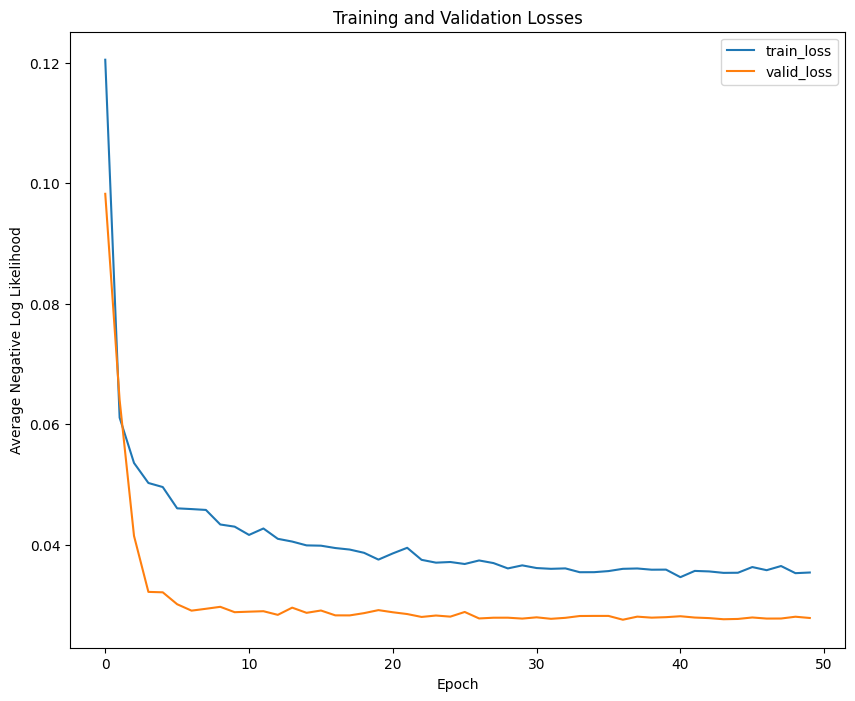

In [21]:
plt.figure(figsize=(10, 8))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch',color='k')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

In [22]:
def save_checkpoint(model, path):

    # Basic details
    checkpoint = {
                'epochs': model.epochs
                 }

    # Extract the final classifier and the state dictionary
    checkpoint['fc'] = model._fc
    checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
    # Save the data to the path
    torch.save(checkpoint, path)

In [23]:
save_checkpoint(model, path=checkpoint)

In [24]:
def check_mse_on_test(model, testloader, criterion=None, device='cpu'):
    loss = 0
    test_loss = 0
    std_mean = 0
    model.eval()
    test_dataframe = pd.read_csv(test_filename)
    with torch.no_grad():
        for data,target in testloader:
            if gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)

            test_dataframe ['predicted output'] = np.squeeze(output.cpu().numpy())
            test_dataframe.to_csv("/content/drive/MyDrive/Dataset/HC18 (Medical Image)/csv_dir/test_file.csv", index=False, encoding='utf8')

            std_mean = torch.std_mean(output)
            loss = criterion(output, target.float())
            test_loss += loss.item() * data.size(0)

    return std_mean , test_loss / len(testloader.dataset)

In [25]:
criterion = nn.L1Loss()

In [26]:
std_mean , test_loss = check_mse_on_test(model, dataloaders['test'], criterion, device='cuda')
print('Test set MAE loss = {:.4f} '.format(test_loss))
print('Test set standard deviation of Hc =  {:.4f} mm'.format(std_mean[0] * 346.4))
print('Test set MAE loss of HC = {:.4f} mm'.format(test_loss * 346.4))

Test set MAE loss = 0.1279 
Test set standard deviation of Hc =  3.7729 mm
Test set MAE loss of HC = 44.3148 mm


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([121])) that is different to the input size (torch.Size([121, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
